In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from collections import Counter

In [2]:
def load_author_specter():
    """"""
    fin = open('dataset/researcher_specter.pkl', 'rb')
    unpickler = pickle.Unpickler(fin)
    pids = []
    vec = []
    while True:
        try:
            data = unpickler.load()
        except EOFError:
            break
        pids.append(data[0])
        vec.append(data[1])
    fin.close()
    return pids, np.array(vec)

pids, pid_specter = load_author_specter()
len(pids), pid_specter.shape

(494455, (494455, 768))

In [3]:
reducer = umap.UMAP()

In [4]:
pid_specter_xy = reducer.fit_transform(pid_specter)
pid_specter_xy.shape

(494455, 2)

In [9]:
area_alias = {
    'neuro': 'neuroscience',
    'etree': 'engineering',
    'computerscience': 'computer science',
    'educ': 'education',
    'cellbio': 'cell biology',
    'econ': 'economics',
    'evol': 'evolution',
    'polisci': 'political science',
    'ling': 'linguistics',
    'phil': 'philosophy',
    'psych': 'psychology'
}

def get_author_viz_df():
    """"""
    df = pd.Series(pids, name='PID').to_frame()
    profile_df = pd.read_csv('dataset/researcher.csv', dtype=str).fillna('')
    pid_to_name = {
        e[0]: ' '.join(' '.join(e[1:]).split())
        for e in zip(profile_df.PID, profile_df.FirstName, profile_df.MiddleName, profile_df.LastName)}
    df['name'] = df.PID.apply(lambda x: pid_to_name[x])
    pid_to_area = {a: b.split(',')[0] for a, b in zip(profile_df.PID, profile_df.ResearchArea)}
    df['area'] = df.PID.apply(lambda x: area_alias.get(pid_to_area[x], pid_to_area[x]))
    df['umap_x'] = pid_specter_xy[:, 0]
    df['umap_y'] = pid_specter_xy[:, 1]
    return df

author_viz_df = get_author_viz_df()
author_viz_df.shape

(494455, 5)

In [10]:
author_viz_df.area.value_counts()[:20]

neuroscience         93294
chemistry            83691
engineering          44854
physics              37219
math                 22327
computer science     18250
education            17950
cell biology         17787
microbiology         14738
economics            12780
sociology            12541
evolution            10071
political science     8608
literature            7434
linguistics           6205
philosophy            6151
nursing               6149
anthropology          5998
psychology            5441
epidemiology          5088
Name: area, dtype: int64

In [11]:
author_viz_df[['umap_x', 'umap_y']].describe()

,umap_x,umap_y
count,494455.000000,494455.000000
mean,7.980061,3.028288
std,2.955073,6.431522
min,-3.011834,-10.552024
25%,6.170048,-1.929341
50%,8.135578,2.408793
75%,9.781261,8.613028
max,20.051996,14.697472


In [12]:
def get_area_color():
    """"""
    area_cnt = author_viz_df.area.value_counts()
    result = dict(zip(area_cnt[:10].index, sns.color_palette().as_hex()))
    result.update(dict(zip(area_cnt[10:19].index, sns.color_palette("Set2").as_hex()[:-1])))
    return result

area_color = get_area_color()
len(area_color)

17

In [13]:
area_color

{'neuroscience': '#1f77b4',
 'chemistry': '#ff7f0e',
 'engineering': '#2ca02c',
 'physics': '#d62728',
 'math': '#9467bd',
 'computer science': '#8c564b',
 'education': '#e377c2',
 'cell biology': '#7f7f7f',
 'microbiology': '#bcbd22',
 'economics': '#17becf',
 'sociology': '#66c2a5',
 'evolution': '#fc8d62',
 'political science': '#8da0cb',
 'literature': '#e78ac3',
 'linguistics': '#a6d854',
 'philosophy': '#ffd92f',
 'nursing': '#e5c494'}

In [14]:
author_viz_df['color'] = author_viz_df.area.apply(lambda x: area_color.get(x, '#808080'))

In [15]:
author_viz_df.head()

,PID,name,area,umap_x,umap_y,color
0,1,STEPHEN V DAVID,neuroscience,9.873412,5.612042,#1f77b4
1,2,BENJAMIN Y HAYDEN,neuroscience,8.733528,6.975849,#1f77b4
2,3,JACK L GALLANT,neuroscience,9.513102,6.660811,#1f77b4
3,4,BENJAMIN WILLMORE,neuroscience,9.884325,6.150750,#1f77b4
4,5,KENDRICK NORRIS KAY,neuroscience,9.384678,6.713326,#1f77b4


In [16]:
author_viz_df.to_csv(
    'results/researcher_specter_viz.tsv', sep='\t', index=False,
    header=['pid', 'x', 'y', 'name', 'area', 'color'])

In [17]:
sample = author_viz_df.sample(frac=.2)
sample.shape

(98891, 6)

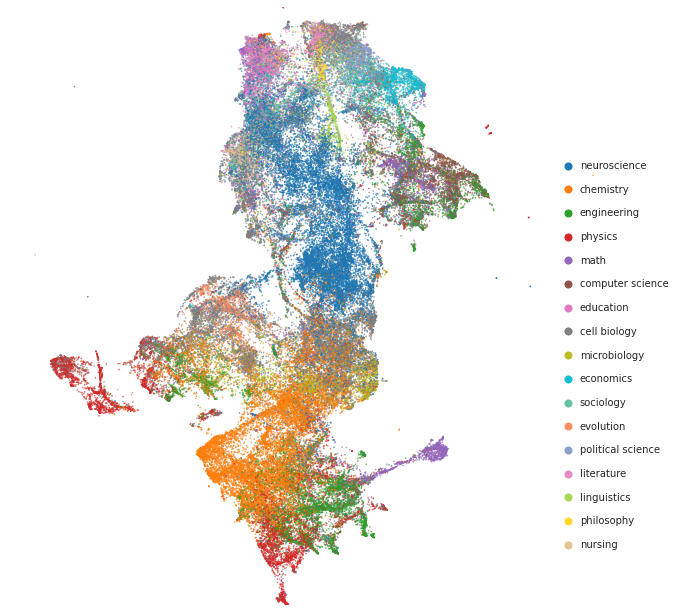

In [20]:
def plot_author_specter(save=False):
    """"""
    fig = plt.figure(figsize=(11,11))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.scatter(
        sample.umap_x,
        sample.umap_y,
        color=sample.color,
        s=.5,
        alpha=.6
    )
    top = 8
    for i, k in enumerate(author_viz_df.area.value_counts()[:17].index):
        ax.scatter(19, top-i, s=50, color=area_color[k])
        ax.text(19.5, top-i, k, va='center')
    ax.set(ylim=[sample.umap_y.min(), sample.umap_y.max()])
    if save:
        plt.savefig('fig/author_specter_umap.jpg', bbox_inches='tight', dpi=240)

plot_author_specter(True)